In [1]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import genetools
import shap
import joblib

from malid.trained_model_wrappers import VJGeneSpecificSequenceModelRollupClassifier
from malid import io, config
from malid.datamodels import GeneLocus, TargetObsColumnEnum

SHAP analysis highlighted IGHV3-7, IgG for T1D. Let's look at the raw feature values in one fold.

In [2]:
fold_id = 1
fold_label = "test"

In [3]:
adata_bcr = io.load_fold_embeddings(
    fold_id=fold_id,
    fold_label=fold_label,
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease,
)

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/a8ec2a8d7e77231cb7a3b56a8ab70b4db67ff80a760932bfa7818be7.1.test.h5ad", "time": "2024-08-17T04:32:55.526465"}


Only considering the two last: ['.test', '.h5ad'].
Only considering the two last: ['.test', '.h5ad'].


In [4]:
clf_bcr = VJGeneSpecificSequenceModelRollupClassifier(
    # First, all the usual parameters, like fold ID, sequencing locus, and classification target:
    fold_id=fold_id,
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease,
    #
    # Model 3 includes a seqeunce stage and an aggregation stage.
    # The aggregation stage is trained on top of the sequence stage, so to speak.
    # First, provide the sequence stage model name:
    base_sequence_model_name=config.metamodel_base_model_names.base_sequence_model_name[
        GeneLocus.BCR
    ],
    # The sequence stage was trained on train_smaller1:
    base_model_train_fold_label="train_smaller1",
    #
    # Next, provide the aggregation stage model name here:
    rollup_model_name=config.metamodel_base_model_names.aggregation_sequence_model_name[
        GeneLocus.BCR
    ],
    # The aggregation stage was trained on train_smaller2:
    fold_label_train="train_smaller2",
)
clf_bcr

VJGeneSpecificSequenceModelRollupClassifier: Pipeline(steps=[('matchvariables', MatchVariables()),
                ('standardscalerthatpreservesinputtype',
                 StandardScalerThatPreservesInputType()),
                ('binaryovrclassifierwithfeaturesubsettingbyclass',
                 BinaryOvRClassifierWithFeatureSubsettingByClass(allow_some_classes_to_fail_to_train=True,
                                                                 estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                                                  n_jobs=1,
                                                                                                  random_state=0),
                                                                 feature_name_class_delimeter='_',
                                                                 n_jobs=1))])

In [5]:
clf_bcr._inner

Pipeline(steps=[('matchvariables', MatchVariables()),
                ('standardscalerthatpreservesinputtype',
                 StandardScalerThatPreservesInputType()),
                ('binaryovrclassifierwithfeaturesubsettingbyclass',
                 BinaryOvRClassifierWithFeatureSubsettingByClass(allow_some_classes_to_fail_to_train=True,
                                                                 estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                                                  n_jobs=1,
                                                                                                  random_state=0),
                                                                 feature_name_class_delimeter='_',
                                                                 n_jobs=1))])

In [6]:
featurized_data_bcr = clf_bcr.featurize(adata_bcr)

{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 9294 / 151200 = 6.15%", "time": "2024-08-17T04:42:27.660619"}


In [7]:
featurized_data_bcr.X

,Lupus_IGHV1-2_IGHA,Lupus_IGHV1-2_IGHD-M,Lupus_IGHV1-2_IGHG,Lupus_IGHV3-23_IGHA,Lupus_IGHV3-23_IGHD-M,Lupus_IGHV3-23_IGHG,Lupus_IGHV5-51_IGHA,Lupus_IGHV5-51_IGHD-M,Lupus_IGHV5-51_IGHG,Lupus_IGHV4-b_IGHA,...,HIV_IGHV2-70_IGHA,HIV_IGHV2-70_IGHD-M,HIV_IGHV2-70_IGHG,HIV_IGHV7-4-1_IGHA,HIV_IGHV7-4-1_IGHD-M,HIV_IGHV7-4-1_IGHG,HIV_IGHV1-3_IGHA,HIV_IGHV5-a_IGHA,HIV_IGHV5-a_IGHD-M,HIV_IGHV5-a_IGHG
specimen_label,,,,,,,,,,,,,,,,,,,,,
M111-S001,0.000314,0.007194,-0.004299,-0.041553,-0.026978,0.000686,0.003784,0.011259,-0.000302,0.005600,...,-0.000080,-0.000134,-0.000057,0.000000,-0.000033,0.000000,0.000000,0.000000,0.000000,-0.000000
M111-S002,-0.005875,0.016469,-0.011255,-0.037714,-0.028339,-0.039076,-0.012541,0.025846,-0.005802,0.012332,...,0.000000,-0.000421,0.000000,0.001396,-0.003765,-0.000119,-0.002556,0.000000,0.000000,-0.000000
M111-S004,-0.012846,0.001686,-0.033137,-0.059498,-0.055254,-0.062819,0.000942,0.014305,-0.019007,0.013655,...,-0.000837,-0.000711,0.000762,0.000000,0.000018,-0.000020,-0.003708,0.000000,0.000000,-0.000000
M111-S005,0.000991,0.011290,0.001490,0.019916,0.047805,-0.001637,0.020311,-0.011812,0.002290,0.026149,...,-0.000556,-0.000376,0.000202,0.000062,-0.000250,-0.000073,-0.000912,0.000000,0.000000,-0.000000
M111-S010,0.005232,0.009690,0.011156,-0.020425,0.019660,0.012118,-0.012583,0.030626,-0.006195,0.015571,...,-0.000471,-0.000516,0.000073,0.000000,0.000000,0.000000,-0.001434,-0.005650,-0.002422,-0.002240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M64-104,-0.011096,-0.014974,-0.024159,-0.022564,-0.073816,-0.109358,-0.013144,-0.043346,-0.033187,-0.000710,...,-0.002729,-0.001324,0.003260,0.005339,-0.004175,0.015618,0.000508,-0.006515,-0.005147,-0.009570
M64-105,-0.008502,-0.006926,-0.005106,0.014671,-0.025300,-0.036438,0.017081,-0.001051,-0.001844,0.003626,...,-0.000750,-0.000426,-0.000890,0.005344,-0.005950,0.004754,-0.011638,0.000000,0.000000,-0.003760
M64-106,-0.009471,0.003973,-0.002591,-0.042759,0.037828,-0.114474,-0.003196,-0.009425,-0.009171,-0.000696,...,0.000919,0.000314,0.001939,0.000000,-0.000135,-0.002045,-0.014093,-0.003657,-0.004794,0.008894


In [8]:
# we will plot the feature values that go into the model after final scaling
transformed_X_bcr = clf_bcr._inner[:-1].transform(featurized_data_bcr.X)
transformed_X_bcr

,Lupus_IGHV1-2_IGHA,Lupus_IGHV1-2_IGHD-M,Lupus_IGHV1-2_IGHG,Lupus_IGHV3-23_IGHA,Lupus_IGHV3-23_IGHD-M,Lupus_IGHV3-23_IGHG,Lupus_IGHV5-51_IGHA,Lupus_IGHV5-51_IGHD-M,Lupus_IGHV5-51_IGHG,Lupus_IGHV4-b_IGHA,...,HIV_IGHV2-70_IGHA,HIV_IGHV2-70_IGHD-M,HIV_IGHV2-70_IGHG,HIV_IGHV7-4-1_IGHA,HIV_IGHV7-4-1_IGHD-M,HIV_IGHV7-4-1_IGHG,HIV_IGHV1-3_IGHA,HIV_IGHV5-a_IGHA,HIV_IGHV5-a_IGHD-M,HIV_IGHV5-a_IGHG
specimen_label,,,,,,,,,,,,,,,,,,,,,
M111-S001,-0.011951,0.211683,-0.154827,-0.356672,-0.300178,0.176866,0.039775,0.314045,0.037501,0.137589,...,0.209368,0.037721,0.287951,-0.364583,0.388546,0.125473,0.542955,0.667578,0.870295,-0.121328
M111-S002,-0.193502,0.943747,-0.329374,-0.319163,-0.314261,-0.396708,-0.336715,0.812943,-0.124767,0.835145,...,0.245322,-0.068317,0.294892,-0.124324,-0.116475,0.115915,0.234283,0.667578,0.870295,-0.121328
M111-S004,-0.397985,-0.223026,-0.878474,-0.532031,-0.592837,-0.739208,-0.025772,0.418215,-0.514380,0.972260,...,-0.131680,-0.175581,0.388384,-0.364583,0.395543,0.123860,0.095236,0.667578,0.870295,-0.121328
M111-S005,0.007918,0.535004,-0.009545,0.244003,0.473855,0.143351,0.420891,-0.475026,0.113998,2.266941,...,-0.004922,-0.051697,0.319675,-0.353908,0.359265,0.119637,0.432832,0.667578,0.870295,-0.121328
M111-S010,0.132312,0.408741,0.232993,-0.150215,0.182548,0.341766,-0.337673,0.976442,-0.136358,1.170790,...,0.033417,-0.103791,0.303877,-0.364583,0.393050,0.125473,0.369792,0.095811,0.378191,-0.241925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M64-104,-0.346651,-1.537895,-0.653185,-0.171111,-0.784966,-1.410546,-0.350600,-1.553566,-0.932786,-0.516285,...,-0.983624,-0.402270,0.694622,0.554164,-0.172032,1.375301,0.604328,0.008240,-0.175567,-0.636465
M64-105,-0.270563,-0.902743,-0.175069,0.192749,-0.282804,-0.358663,0.346414,-0.106980,-0.007989,-0.066975,...,-0.092509,-0.070200,0.185728,0.555071,-0.412321,0.505881,-0.862333,0.667578,0.870295,-0.323722
M64-106,-0.298989,-0.042526,-0.111963,-0.368461,0.370590,-1.484341,-0.121205,-0.393398,-0.224176,-0.514917,...,0.659279,0.203225,0.532618,-0.364583,0.374816,-0.038181,-1.158668,0.297511,-0.103783,0.357400


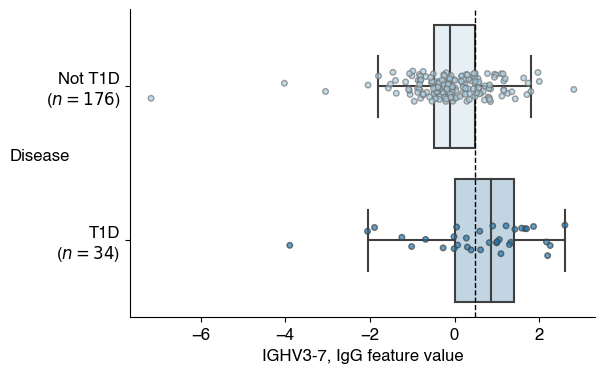

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
feat = "T1D_IGHV3-7_IGHG"
friendly_name = feat.replace("T1D_IGHV3-7_IGHG", "IGHV3-7, IgG")
plot_df = pd.concat(
    [
        transformed_X_bcr[feat],
        (featurized_data_bcr.y == "T1D")
        .map({True: "T1D", False: "Not T1D"})
        .rename("Disease"),
    ],
    axis=1,
)
order = ["Not T1D", "T1D"]
ax = sns.boxplot(
    data=plot_df,
    x=feat,
    y="Disease",
    ax=ax,
    order=order,
    # Disable outlier markers:
    fliersize=0,
    palette=sns.color_palette("Paired")[:2],
    zorder=1,
)
for patch in ax.patches:
    # Set boxplot alpha transparency: https://github.com/mwaskom/seaborn/issues/979#issuecomment-1144615001
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.3))

np.random.seed(123)  # seed for stripplot jitter
sns.stripplot(
    data=plot_df,
    x=feat,
    y="Disease",
    order=order,
    hue="Disease",
    legend=None,
    linewidth=1,
    edgecolor="gray",
    palette=sns.color_palette("Paired")[:2],
    ax=ax,
    zorder=20,
    size=4,
    jitter=0.1,
    alpha=0.7,
)
plt.axvline(
    x=plot_df[plot_df["Disease"] == "Not T1D"][feat].describe().loc["75%"],
    linestyle="dashed",
    zorder=10,
    linewidth=1,
    # color=sns.color_palette("Paired")[0],
    color="k",
)
plt.xlabel(f"{friendly_name} feature value")
ax.set_yticklabels(
    genetools.plots.add_sample_size_to_labels(
        labels=ax.get_yticklabels(),
        data=plot_df,
        hue_key="Disease",
    )
)
plt.ylabel("Disease", rotation=0)
sns.despine(ax=ax)
genetools.plots.savefig(
    fig,
    clf_bcr.output_base_dir
    / f"{clf_bcr.fold_label_train}.feature_values.{clf_bcr.rollup_model_name}.fold_{clf_bcr.fold_id}.{fold_label}.png",
    dpi=300,
)